In this notebook, we build on the model training of Exploration 2 in the real-time listening and processing of Exploration 3, to build a single unified workflow. Running this allows you to, in this one self-contained notebook,
* specify the noises you want your model to recognize
* record training and testing data for those noises
* train a model on the data, and evaluate its performance
* use the model with a listener to recognize noises in real-time and act on them

As in Exploration 3, we will use sounddevice to listen and record audio. This outputs numpy arrays. We will use this to construct training and testing datasets, which will pass mel spectrograms on to the network. Once trained, this network will be used to recognize noises, again by converting incoming audio into spectrograms and generating predictions.

# Real-time listening: general functions

Functions to continuously listen for noises, and pass them to a processing function.

In [1]:
import sounddevice as sd
import numpy as np
import queue
import time

In [2]:
########### PARAMETERS ###########

device = 2 # select the microphone. Use sd.query_devices() to see options
print(sd.query_devices())

BATCH_DURATION = 0.02      # listen for noises BATCH_DURATION (seconds) at a time
THRESHOLD_MULTIPLIER = 5   # detect a spike when the next batch is at least THRESHOLD_MULTIPLIER times bigger
THRESHOLD_ABSOLUTE = 0.005 # ignore any spikes that don't rise above this. Too many false positives without this
BATCHES_PER_NOISE = 3      # collect BATCHES_PER_NOISE batches of audio input per detected noise

samplerate = sd.query_devices(device, 'input')['default_samplerate']
# optional for future: set the FFT window size based on the sample rate

blocksize = int(samplerate * BATCH_DURATION) # get the block (batch) size in frames

  0 Built-in Microphone, Core Audio (2 in, 0 out)
< 1 Built-in Output, Core Audio (0 in, 2 out)
> 2 SpeechMatic USB MultiAdapter, Core Audio (1 in, 2 out)


In [3]:
########### Functions for continuous listening and processing ###########

# bundling these is easier than declaring them 'global' in the below
class listen:
    """ Helper variables for processing continuous audio input """
    
    def reset():
        listen.prev_max = 1.
        listen.batches_to_collect = 0
        listen.batches_collected = 0
        listen.current_noise = None
        listen.start = time.time()

        listen.processing_start = 0 # for timing the total processing time
        listen.processing_end = 0

        listen.q_batches = queue.Queue() # a FIFO queue
        listen.all_audio = []  # could use this to collect all audio (uncomment line in callback)
        listen.all_noises = [] # could use this to collect all noises. Use the processing_function to append
    
def callback(indata, frames, time_pa, status):
    """ Detect if a noise has been made, and add audio to the queue. """
    if status:
        print('STATUS: ', str(status))
    if any(indata):
        indata_copy = indata.copy()
        new_max = np.absolute(indata_copy).max()
        # listen.all_audio.append(indata_copy)
        
        # Gather audio data if more is required. Make sure to *copy* the input data.
        if listen.batches_to_collect > 0:
            listen.q_batches.put_nowait(indata_copy)
            listen.batches_collected  += 1
            listen.batches_to_collect -= 1
                
        # Otherwise, see if a new noise has been detected
        elif ( new_max > THRESHOLD_ABSOLUTE and
               new_max > THRESHOLD_MULTIPLIER * listen.prev_max ):
            
            listen.processing_start = time.time()
            
            listen.q_batches.put_nowait(indata_copy)
            listen.batches_collected += 1
            listen.batches_to_collect = BATCHES_PER_NOISE - 1 # get more batches
               
        listen.prev_max = new_max
        
    else:
        print('no input')

def time_elapsed(duration):
    def _time_elapsed():
        return time.time() - listen.start > duration
    return _time_elapsed

def print_processing_time():
    listen.processing_end = time.time()
    print('Processing took {:.4f} sec\n'.format(
        listen.processing_end - listen.processing_start))
        
def listen_and_process(processing_function, stop_condition=time_elapsed(3),
                       device=device, print_after_processing=None):
    """ Listen continuously for noises until stop_condition() returns True (default: wait 3 sec).
    As each noises heard, process is using processing_function. Return all noises at the end. """

    listen.reset() # reinitialize helper variables
    
    with sd.InputStream(device=device, channels=1, callback=callback,
                        blocksize=blocksize,
                        samplerate=samplerate):
        print('Listening...')
        while True:
            
            # data collects if it meets the threshold. Process when enough data is in queue:
            if listen.batches_collected >= BATCHES_PER_NOISE:
                data = []
                for _ in range(BATCHES_PER_NOISE):
                    data.append( listen.q_batches.get_nowait() )
                listen.batches_collected -= BATCHES_PER_NOISE
                
                listen.current_noise = np.concatenate( data, axis=None )
                
                processing_function( listen.current_noise )
                
                # print something after processing, if desired
                print_after_processing() if print_after_processing else None
                    
            # listen until the condition is met
            if stop_condition():
                break
        print('Done.')

# Recording audio data for training/testing

We now apply the above functions to make a listener to record training and testing data for our model:

In [4]:
from IPython.display import clear_output

In [5]:
########## A listener to record training/testing data. ##########

# a helper function to get nonnegative integer input
def get_int_input():
    while True:
        response = input() # response is a string
        try:
            val = int(response)
            if val >= 0:
                break
            print('Integer must be non-negative.')
        except:
            print('Please enter an integer.')
        
    return val

def record_model_data(device=device):
    """ Prompts the user to label and record noise samples. Returns a dictionary with labels as keys
    and lists of flattened numpy arrays (one array per noise sample) as values. """
    
    noise_data_dict = {}
    noise_count = 0
    
    def gather_and_progress(label, total):
        def _gather_and_progress(rec):
            nonlocal noise_count
            
            listen.all_noises.append( rec )
            noise_count += 1
            print(noise_count, end=', ')

        return _gather_and_progress
        
    while True:
        print('Enter text label for next noise (leave blank to exit):')
        label = input()
        if not label:
            return noise_data_dict
        if label in noise_data_dict:
            print('You have already recorded {} samples of this noise. You may now record more.'.format(
                    len(noise_data_dict[label]))
                 )
        
        print('How many noise samples would you like to record?')
        num = get_int_input()
        if num == 0:
            continue
        
        clear_output() # clear jupyter output
        print('Please start recording.\n')
        print('"{}" noises recorded (out of {}): '.format(label, num))
        noise_count = 0
        listen_and_process(processing_function=gather_and_progress(label, num), 
                           stop_condition=lambda: noise_count >= num,
                           device=device,
                           print_after_processing=None)
        print('')

        # save the list of recorded noises
        if label in noise_data_dict:
            noise_data_dict[label] += listen.all_noises.copy()
        else:
            noise_data_dict[label] = listen.all_noises.copy()
        
    return noise_data_dict

In [6]:
# TESTING
my_recordings = record_model_data()
print(my_recordings)

Please start recording.

"tsk" noises recorded (out of 8): 
Listening...
1, 2, 3, 4, 5, 6, 7, 8, Done.

Enter text label for next noise (leave blank to exit):

{'t': [array([-0.00033569, -0.00039673, -0.00039673, ..., -0.00073242,
       -0.00109863, -0.0015564 ], dtype=float32), array([ 0.0000000e+00,  3.0517578e-05, -6.1035156e-05, ...,
        6.3476562e-03,  6.8359375e-03,  7.1716309e-03], dtype=float32), array([ 0.0005188 ,  0.00057983,  0.00042725, ..., -0.00701904,
       -0.00698853, -0.00701904], dtype=float32), array([-0.00024414, -0.00018311, -0.00027466, ..., -0.00735474,
       -0.00723267, -0.00704956], dtype=float32), array([-0.00027466, -0.00033569, -0.00015259, ..., -0.01522827,
       -0.01522827, -0.01525879], dtype=float32)], 'p': [array([-0.00015259, -0.00012207,  0.        , ..., -0.01361084,
       -0.01370239, -0.01391602], dtype=float32), array([1.5258789e-04, 0.0000000e+00, 9.1552734e-05, ..., 2.0751953e-03,
       2.1972656e-03, 2.1667480e-03], dtype=float32)

# Audio processing: preparing spectrograms

A function to create a spectrogram from a noise sample recording.

In [14]:
import torch
import torchaudio.transforms
import matplotlib.pyplot as plt

In [15]:
########### PARAMETERS ###########
N_MELS = 28                # the number of mel filterbanks in each spectrogram

In [9]:
def generate_spectrogram(noise_sample, samplerate, n_mels):
    """ Takes a noise_sample as a flattened numpy.array,
    and returns a mel spectrogram as a 2D torch.tensor """
    
    # normalize to have unit mean, and compute the spectrogram
    normed_sample = torch.from_numpy(noise_sample) / noise_sample.mean()
    mel = torchaudio.transforms.MelSpectrogram(
        sample_rate=samplerate, n_mels=n_mels)(normed_sample)
    
    return mel.log2()

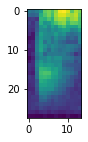

In [10]:
# TESTING
my_spectrogram = generate_spectrogram(
                    noise_sample=my_recordings['t'][0],
                    samplerate=samplerate,
                    n_mels=N_MELS)
plt.figure(figsize=(2, 2))
plt.imshow(my_spectrogram)

# Neural net: preparing datasets

From a dictionary of labeled noise sample recordings, prepare the datasets and data loaders needed to train and test the model. Some of the model construction, training, and evaluation code here has been adapted from a [pytorch tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py).

In [11]:
from torch.utils.data import Dataset, DataLoader

In [12]:
# Prepare the noise data for handing to the convolutional neural network, for training and testing

class NoisesDataset(Dataset):
    """ Noises dataset. Takes a dictionary of recordings and returns spectrograms when data is requested. 
    A channel dimension is added to each spectrogram, as needed for the CNN. """

    def __init__(self, noise_data_dict, samplerate, n_mels): 
        """ Initialization: 
        Takes a dictionary of noise samples, with labels as keys and lists of
        flattened numpy arrays (one array per noise sample) as values. 
        Computes spectrograms for each. """
        self.noise_data_dict = noise_data_dict
        self.noise_samples = []
        self.labels = []
        
        self.noise_str_to_int = {} # correspondences between integer and string labels
        self.noise_int_to_str = {} 
        i = 0
        
        for label, list_of_arrays in noise_data_dict.items():
            # extract samples and labels from the dictionary
            num_samples = len(noise_data_dict[label])
            self.noise_samples += noise_data_dict[label]
            self.labels += [label] * num_samples
            
            # assign a unique integer to each string label
            if label not in self.noise_str_to_int:
                self.noise_str_to_int[label] = i
                self.noise_int_to_str[i] = label
                i += 1
        
        # compute spectrograms, and convert labels to integers
        self.spectrograms = [ generate_spectrogram(s, samplerate, n_mels) 
                              for s in self.noise_samples ]
        self.labels = [ self.noise_str_to_int[ L ] for L in self.labels ]

    def __len__(self):
        " Return  the total number of samples "
        return len(self.labels)

    def __getitem__(self, sample_index):
        " Return one sample of data "
        # Load data and get (integer) label
        # Note the CNN will expect the first tensor dimension to be the channel, hence the unsqueeze
        X = self.spectrograms[sample_index].unsqueeze(0)
        y = self.labels[sample_index]

        return X, y

# adapted from https://stackoverflow.com/questions/53916594/typeerror-object-of-type-numpy-int64-has-no-len
def prepare_data_loaders(full_dataset, training_fraction=0.8, batch_size=8):
    """ Prepare data loaders for training and testing of the model. """

    train_size = int(training_fraction * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

    train_params = {
        'batch_size': batch_size,
        'shuffle': True,
        'num_workers': 1,
    }
    train_loader = DataLoader(dataset=train_dataset, **train_params)
    test_loader  = DataLoader(dataset=test_dataset)
    
    return train_loader, test_loader, train_dataset, test_dataset

 tsk    p    p  tsk    t    t  tsk    t


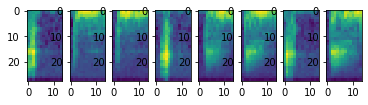

In [93]:
# TESTING
my_dataset = NoisesDataset(my_recordings, samplerate, N_MELS)
my_train_loader, my_test_loader, my_train_dataset, my_test_dataset = prepare_data_loaders(my_dataset, batch_size=8)

# get some random training spectrograms
my_train_dataiter = iter(my_train_loader)
my_spectrograms, my_labels = my_train_dataiter.next()
my_batch_size = 8

# show spectrograms and print labels
fig, ax = plt.subplots(1, my_batch_size)
for i in range(len(my_spectrograms)):
    ax[i].imshow(my_spectrograms[i][0].numpy()) # the 0 selects the first (only) channel
print(' '.join('{:>4s}'.format(my_dataset.noise_int_to_str[my_labels[j].item()]) for j in range(my_batch_size)))

# Neural net: defining and training

Define the convolutional neural network, and train it.

In [26]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [27]:
class Net(nn.Module):
    def __init__(self, image_size, N_noises):
        super(Net, self).__init__()
        
        # image_size is a 2-tuple, the expected dimensions of each spectrogram
        h, w = image_size
        
        # number of output nodes, (square) kernel size, and pool size per convolution layer,
        # assuming the stride for pooling is the same as the pool size
        kernels = [3, 3]
        pool = 2
        
        # compute the number of input nodes for the first dense layer
        h_out, w_out = h, w
        for k in kernels:
            # the convolution.
            h_out += -k + 1
            w_out += -k + 1
            
            # the pool. (from help(torch.nn.MaxPool2d))
            h_out = int( (h_out - pool) / pool + 1 )
            w_out = int( (w_out - pool) / pool + 1 )
            
        self.image_out = h_out * w_out
        
        # define the layers. The numbers of nodes chosen do not have deep thought behind them.
        self.conv0 = nn.Conv2d(1, 32, kernels[0])
        self.pool = nn.MaxPool2d(2)
        self.conv1 = nn.Conv2d(32, 10, kernels[1])
        self.fc0 = nn.Linear(10 * self.image_out, 50)
        self.fc1 = nn.Linear(50, 10)
        # number of output nodes for final dense layer: the number of noise types        
        self.fc2 = nn.Linear(10, N_noises)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv0(x)))
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 10 * self.image_out)
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [64]:
def train_net(net, epochs, train_loader, batch_progress=50):
    """ Use training data from train_loader to train net for a number of epochs,
    using a cross entropy loss function and Adam as the optimizer. """
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters())
    
    batch_num = 0
    for epoch in range(epochs):  # loop over the dataset multiple times
        
        batch_running_loss = 0.0
        
        for i, data in enumerate(train_loader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # accrue loss for printing
            batch_running_loss += loss.item()
            
            if batch_num % batch_progress == batch_progress-1:
                print('[{:d}, {:5d}] loss: {:.3f}'.format(
                  epoch + 1, i + 1, batch_running_loss / batch_progress))
                batch_running_loss = 0.0
                batch_num = 0
            
            batch_num += 1
        
    print('Finished Training')

In [65]:
# TESTING
my_net = Net(my_spectrogram.size(), len(my_recordings))
train_net(my_net, 5, my_train_loader, batch_progress=1)

[1,     1] loss: 1.161
[1,     2] loss: 0.898
[2,     1] loss: 1.010
[2,     2] loss: 1.013
[3,     1] loss: 0.836
[3,     2] loss: 1.168
[4,     1] loss: 0.973
[4,     2] loss: 0.950
[5,     1] loss: 0.949
[5,     2] loss: 0.943
Finished Training


# Evaluate model quality

Check the accuracy of the model against the testing and training sets, and compute the confusion matrix.

In [52]:
import itertools
from sklearn.metrics import confusion_matrix

In [80]:
def accuracy_rating(net, dataloader, dataset_label):
    correct = 0
    total = 0
    all_targets = torch.tensor([], dtype=torch.long)
    all_predictions = torch.tensor([], dtype=torch.long)
    with torch.no_grad():
        for data in dataloader:
            spectrograms, labels = data
            outputs = net(spectrograms)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_predictions = torch.cat( 
                (all_predictions, predicted), dim=0 )
            all_targets = torch.cat( 
                (all_targets, labels), dim=0 )
            
    print('Accuracy of the network on the {} {} spectrograms: {:.0f} %'.format(
        total,
        dataset_label,
        100 * correct / total))
    
    return all_predictions, all_targets

In [81]:
# adapted from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(predictions, targets, labels_int_to_str, 
                          normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    stacked = torch.stack( [targets, predictions], dim=1 )
    all_int_labels = sorted(list(labels_int_to_str.keys()))
    num_labels = len(all_int_labels)
    confusion_matrix = torch.zeros(num_labels, num_labels, dtype=torch.int64)

    for pair in stacked:
        target_label, prediction_label = pair.tolist()
        confusion_matrix[target_label, prediction_label] += 1

    classes = [ labels_int_to_str[i] for i in all_int_labels ]    
    cm = confusion_matrix # rename for compactness
        
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization:')

        
    size = min(num_labels + 1, 8)
    plt.figure(figsize=(size, size))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", 
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    return confusion_matrix

Accuracy of the network on the 13 training spectrograms: 38 %
Accuracy of the network on the 4 test spectrograms: 0 %
Confusion matrix, without normalization:


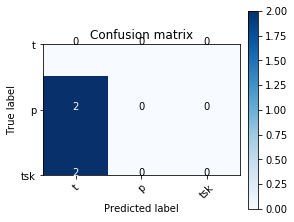

In [82]:
# TESTING
accuracy_rating(my_net, my_train_loader, 'training')
preds, targets = accuracy_rating(my_net, my_test_loader, 'test')

plot_confusion_matrix(preds, targets, my_dataset.noise_int_to_str);